In [1]:
import sys
sys.path.append('..')

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from sklearn.cluster import KMeans

from myutils.stats import corrcoef, acfunc
from myutils.matplotlib import seaborn_theme

from src.pca import IPCA
from src.rzd import PlacePriceModel

seaborn_theme()

In [3]:
data = pd.read_csv('../data/data.csv', parse_dates=['date'], encoding='utf-8')

weekdays = data[['weekday', 'day_name']].drop_duplicates().sort_values(by='weekday')\
    .set_index('weekday')['day_name'].to_dict()

data.head(2)

,date,days,places,price,num,class,train,departure_timestamp,arrival_timestamp,weekday,day_name,places_frac
0,2021-04-03,1,62.0,3275.0,001А,Купе,001А-Купе,86100.0,28500.0,5,Saturday,0.442857
1,2021-04-04,1,33.0,3913.0,001А,Купе,001А-Купе,86100.0,28500.0,6,Sunday,0.235714


In [4]:
trains = sorted(data['train'].unique().tolist())
len(trains)

112

## Модель

$$
\begin{cases}
    n(t, \tau) = \mu(\tau) + a(t) V(\tau) + \delta(t, \tau) \\
    C(t, \tau) = b_0 + b_1 n(t, \tau) + \varepsilon(t, \tau)
\end{cases}
$$

Значения метрик (доля объяснённой дисперсии для PCA и коэф-т детерминации для лин. регрессии) по разным поездам.

In [5]:
maxdays = 30

In [6]:
models = {}
metrics = []

for train in trains:
    train_data = data[(data['train'] == train) & (data['days'] <= maxdays)]

    places = train_data.pivot(index='date', columns='days', values='places_frac')
    prices = train_data.pivot(index='date', columns='days', values='price')
    
    model = PlacePriceModel()
    
    try:
        model.fit(places, prices)
        models[train] = model
        
        train_num, train_class = train.split('-')
        metrics.append((train_num, train_class, model.explained_variance, model.r2))
        
    except Exception as e:
        print(train, e)
    
metrics = pd.DataFrame(metrics, columns=['num', 'class', 'explained', 'r2'])
metrics['train'] = metrics['num'] + '-' + metrics['class']

metrics.head()

707Н-Сидячий did not converge in 500 iterations. best score: 0.00030611864896187607 > 1e-05


,num,class,explained,r2,train
0,001А,Купе,0.893505,0.202094,001А-Купе
1,002А,Купе,0.866219,0.235136,002А-Купе
2,005А,СВ,0.892166,0.212565,005А-СВ
3,006А,СВ,0.907336,0.195554,006А-СВ
4,701Н,СВ,0.698355,0.645636,701Н-СВ


In [7]:
def truncate_values(df: pd.DataFrame, th: float, fill_value: float = np.nan) -> pd.DataFrame:
    df = df.copy()
    df.values[np.abs(df.values) < th] = fill_value
    
    return df

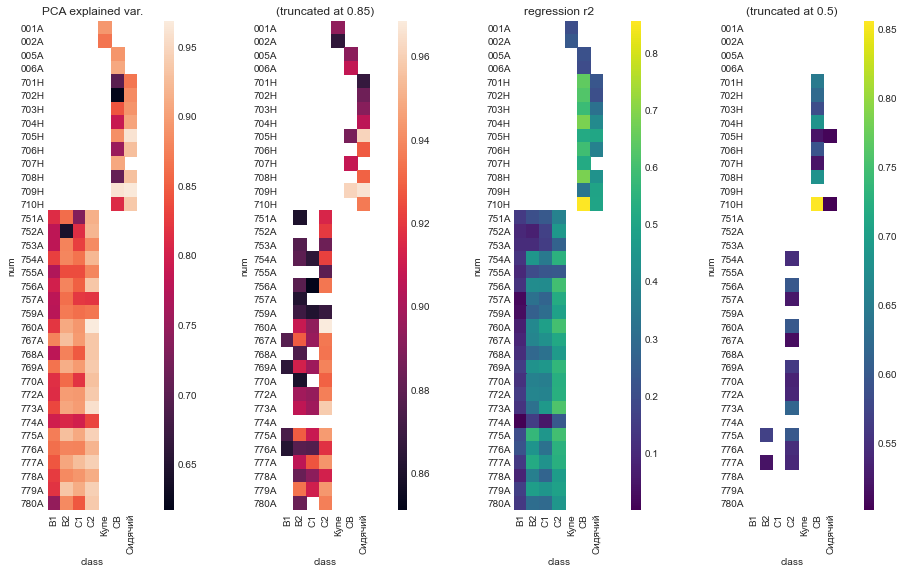

In [8]:
fig, axes = plt.subplots(ncols=4)
fig.set_size_inches(15, 9)
fig.subplots_adjust(wspace=0.7)
ax1, ax2, ax3, ax4 = axes.flatten()

explained = metrics.pivot(index='num', columns='class', values='explained')
r2 = metrics.pivot(index='num', columns='class', values='r2')

sns.heatmap(explained, ax=ax1, cbar_kws={'aspect': 50, 'pad': 0.2})
ax1.set_title('PCA explained var.')

explained = truncate_values(explained, th=0.85)

sns.heatmap(explained, ax=ax2, cbar_kws={'aspect': 50, 'pad': 0.2})
ax2.set_title('(truncated at 0.85)')

sns.heatmap(r2, ax=ax3, cmap='viridis', cbar_kws={'aspect': 50, 'pad': 0.2})
ax3.set_title('regression r2')

r2 = truncate_values(r2, th=0.5)

sns.heatmap(r2, ax=ax4, cmap='viridis', cbar_kws={'aspect': 50, 'pad': 0.2})
ax4.set_title('(truncated at 0.5)')

plt.savefig('../data/figures/model_metrics.pdf', transparent=True, bbox_inches='tight')
# plt.close()

In [9]:
metrics[metrics['explained'] <= 0.65]

,num,class,explained,r2,train
6,702Н,СВ,0.617027,0.622936,702Н-СВ
28,752А,B2,0.642676,0.075598,752А-B2


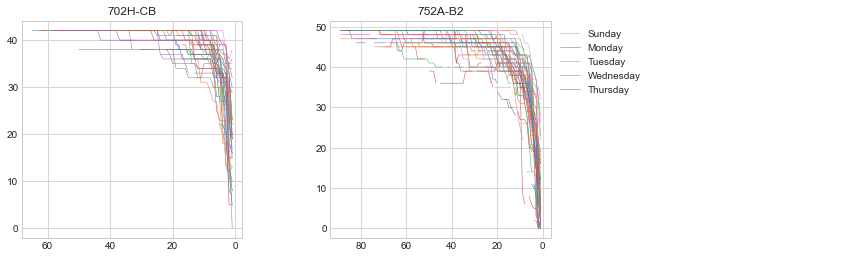

In [10]:
mask = metrics['explained'] <= 0.65

ncols = 3
nrows = mask.sum() // ncols + (mask.sum() % ncols > 0)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows)
fig.set_size_inches(5 * ncols, 4 * nrows)
fig.subplots_adjust(wspace=0.4, hspace=0.5)
axes = axes.flatten()

for train, ax in zip(metrics.loc[mask, 'train'], axes):
    train_data = data[data['train'] == train]\
        .pivot(index='date', columns='days', values='places')
    
    for date, row in train_data.iterrows():
        weekday = date.weekday()
        
        _, labels = ax.get_legend_handles_labels()
        
        label = weekdays[weekday]
        
        if label in labels:
            label = None
        
        ax.plot(row, c=f'C{weekday}', lw=0.5, label=label)
    
    ax.set_title(train)
    ax.invert_xaxis()
    
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
for i in range(mask.sum(), len(axes)):
    axes[i].axis('off')

### Визуализация парной регрессии по поездам

## PCA

In [11]:
a = {}
mean = {}
v = {}

for train, model in models.items():
    if model.explained_variance >= 0.85:
        a[train] = model.a
        mean[train] = model.mean
        v[train] = model.v

a = pd.DataFrame(a)
v = pd.DataFrame(v).T
mean = pd.DataFrame(mean).T

a.reset_index().to_csv('../data/principal_components.csv', index=False)

### $a(t)$

In [12]:
ncols = 6
nrows = a.shape[1] // ncols + (a.shape[1] % ncols > 0)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows)
fig.set_size_inches(4 * ncols, 3 * nrows)
fig.subplots_adjust(wspace=0.3, hspace=0.75)
axes = axes.flatten()

for train, ax in zip(a.columns, axes):
    a[train].plot(ax=ax, c='C2', lw=1, marker='.', markersize=2)
    
    ax.set_title(train)
    ax.set_xlabel(None)

for i in range(a.shape[1], len(axes)):
    axes[i].axis('off')
    
plt.savefig('../data/figures/pcs.pdf', transparent=True, bbox_inches='tight')
plt.close()

In [13]:
ncols = 6
nrows = a.shape[1] // ncols + (a.shape[1] % ncols > 0)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows)
fig.set_size_inches(4 * ncols, 3 * nrows)
fig.subplots_adjust(wspace=0.3, hspace=0.5)
axes = axes.flatten()

for train, ax in zip(a.columns, axes):
    s = a[train].copy()
    s = s.dropna()
    
    acf = acfunc(s, method='spearman', maxlag=21)
    
    ax.plot(acf, lw=1)
    ax.fill_between(acf.index, acf.values, alpha=0.2)
    
    vmax = acf.abs().max() * 1.1
    ax.set_ylim(-vmax, vmax)
    
    ax.axhline(c='k', lw=0.5, ls='dashed', zorder=1)
    ax.set_title(train)

for i in range(a.shape[1], len(axes)):
    axes[i].axis('off')
    
plt.savefig('../data/figures/pcs_acf.pdf', transparent=True, bbox_inches='tight')
plt.close()

## Кластеризация по $\mu(\tau)$

In [14]:
integral_mean = (mean - mean.shift(axis=1)).drop(columns=1)

integral_mean.head(2)

days,2,3,4,5,6,7,8,9,10,11,...,21,22,23,24,25,26,27,28,29,30
001А-Купе,0.040054,0.050287,0.049735,0.047743,0.031868,0.034278,0.027408,0.022341,0.021888,0.018925,...,0.010476,0.001342,0.009694,0.008711,0.014579,0.000004,0.014058,0.003406,-0.000312,0.008947
002А-Купе,0.045111,0.042226,0.046277,0.037982,0.029445,0.022278,0.041331,0.014721,0.027381,0.012166,...,0.011403,0.013943,0.002114,0.010006,0.007127,0.008176,0.008224,0.004356,-0.006314,0.006259


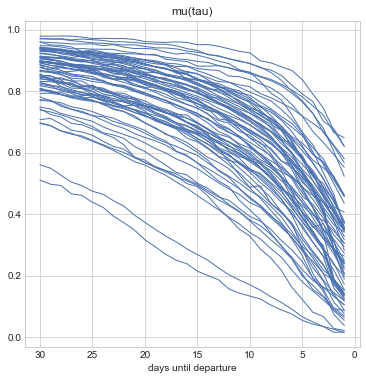

In [15]:
plt.figure(figsize=(6, 6))

for _, row in mean.iterrows():
    plt.plot(row, c='C0', lw=1)
    
plt.gca().invert_xaxis()

plt.title('mu(tau)')
plt.xlabel('days until departure')

plt.savefig('../data/figures/mean_vectors.pdf', transparent=True, bbox_inches='tight')

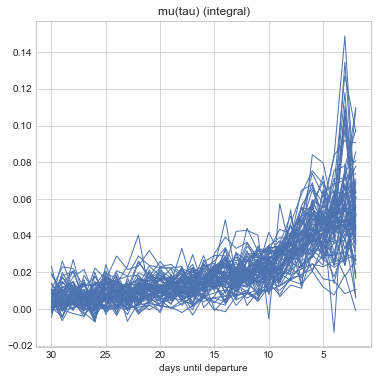

In [16]:
plt.figure(figsize=(6, 6))

for _, row in integral_mean.iterrows():
    plt.plot(row, c='C0', lw=1)
    
plt.gca().invert_xaxis()

plt.title('mu(tau) (integral)')
plt.xlabel('days until departure')

plt.savefig('../data/figures/integral_mean_vectors.pdf', transparent=True, bbox_inches='tight')

Векторы $\mu(\tau)$ по разным кластерам.

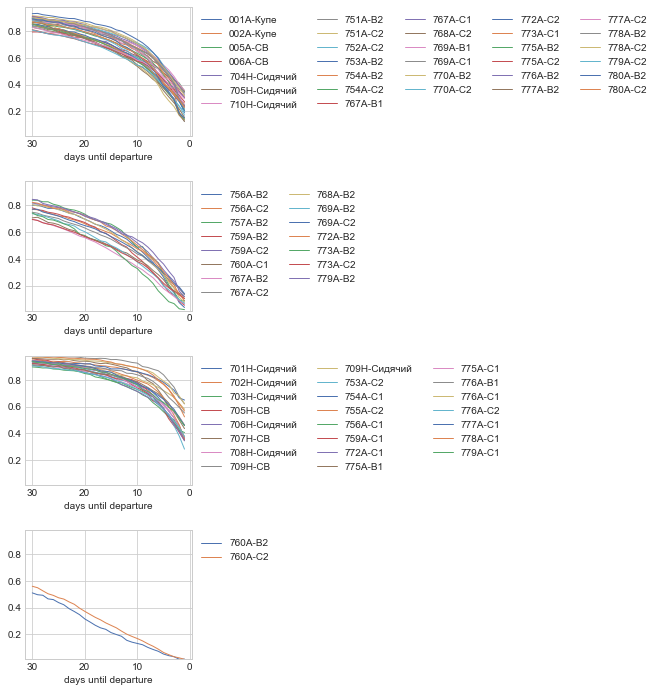

In [17]:
k = 4
kmeans = KMeans(n_clusters=k).fit(mean.values)
mu_clusters = kmeans.predict(mean.values)

ncols = 1
nrows = k

fig, axes = plt.subplots(ncols=ncols, nrows=nrows)
fig.set_size_inches(3 * ncols, 3 * nrows)
fig.subplots_adjust(hspace=0.35)
axes = axes.flatten()

mu_min = mean.min().min()
mu_max = mean.max().max()

for cluster, ax in zip(np.unique(mu_clusters), axes):
    mean_i = mean.loc[mu_clusters == cluster]
    
    mean_i.T.plot(ax=ax, lw=1)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=mean_i.shape[0] // 8 + 1)
    ax.set_xlabel('days until departure')
    ax.set_ylim(mu_min, mu_max)
    
    ax.invert_xaxis()

plt.savefig('../data/figures/mean_vector_clusters.pdf', transparent=True, bbox_inches='tight')
# plt.close()

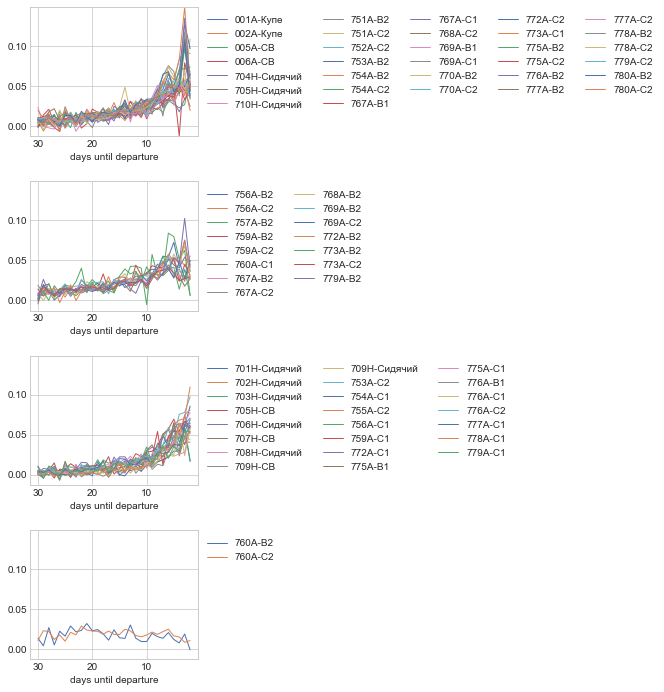

In [18]:
# k = 3
# kmeans = KMeans(n_clusters=k).fit(integral_mean.values)
# mu_clusters = kmeans.predict(integral_mean.values)

ncols = 1
nrows = k

fig, axes = plt.subplots(ncols=ncols, nrows=nrows)
fig.set_size_inches(3 * ncols, 3 * nrows)
fig.subplots_adjust(hspace=0.35)
axes = axes.flatten()

int_mu_min = integral_mean.min().min()
int_mu_max = integral_mean.max().max()

for cluster, ax in zip(np.unique(mu_clusters), axes):
    mean_i = integral_mean.loc[mu_clusters == cluster]
    
    mean_i.T.plot(ax=ax, lw=1)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=mean_i.shape[0] // 8 + 1)
    ax.set_xlabel('days until departure')
    ax.set_ylim(int_mu_min, int_mu_max)
    
    ax.invert_xaxis()

plt.savefig('../data/figures/integral_mean_vector_clusters.pdf', transparent=True, bbox_inches='tight')
# plt.close()

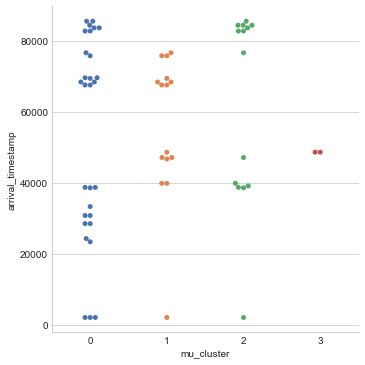

In [19]:
df = pd.Series(mu_clusters, index=mean.index, name='mu_cluster')
df.index.name = 'train'
df = df.reset_index()

df = df.merge(data[['train', 'arrival_timestamp']], on='train', how='left')\
    .drop_duplicates('train').dropna()
df = df.set_index('train')

sns.catplot(data=df, x='mu_cluster', y='arrival_timestamp', kind='swarm')

## Кластеризация по $V(\tau)$

In [20]:
integral_v = (v - v.shift(axis=1)).drop(columns=1)

integral_v.head(2)

days,2,3,4,5,6,7,8,9,10,11,...,21,22,23,24,25,26,27,28,29,30
001А-Купе,0.027054,0.020686,0.004555,0.004388,0.007382,0.009286,-0.000734,-0.006606,-0.024143,-0.004949,...,-0.007535,0.006400,-0.009188,-0.000563,-0.026278,0.015157,-0.004475,0.002219,0.003211,-0.005724
002А-Купе,0.003032,0.014589,0.016073,0.020328,0.007691,0.018021,-0.048377,0.026578,-0.025254,0.000211,...,-0.014317,-0.025685,0.008226,-0.009025,-0.007669,-0.009251,0.004909,-0.009378,0.014800,-0.018156


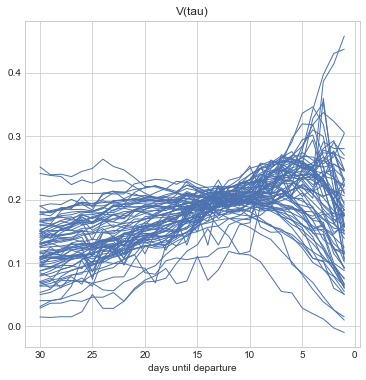

In [21]:
plt.figure(figsize=(6, 6))

for _, row in v.iterrows():
    plt.plot(row, c='C0', lw=1)
    
plt.gca().invert_xaxis()

plt.title('V(tau)')
plt.xlabel('days until departure')

plt.savefig('../data/figures/eigenvectors.pdf', transparent=True, bbox_inches='tight')

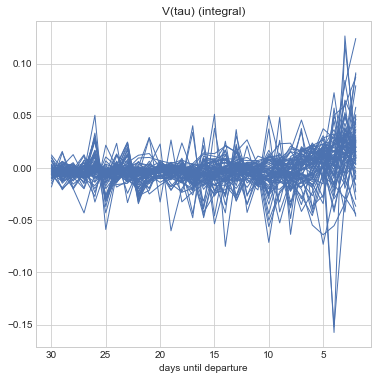

In [22]:
plt.figure(figsize=(6, 6))

for _, row in integral_v.iterrows():
    plt.plot(row, c='C0', lw=1)
    
plt.gca().invert_xaxis()

plt.title('V(tau) (integral)')
plt.xlabel('days until departure')

plt.savefig('../data/figures/integral_eigenvectors.pdf', transparent=True, bbox_inches='tight')

Векторы $V(\tau)$ по разным кластерам.

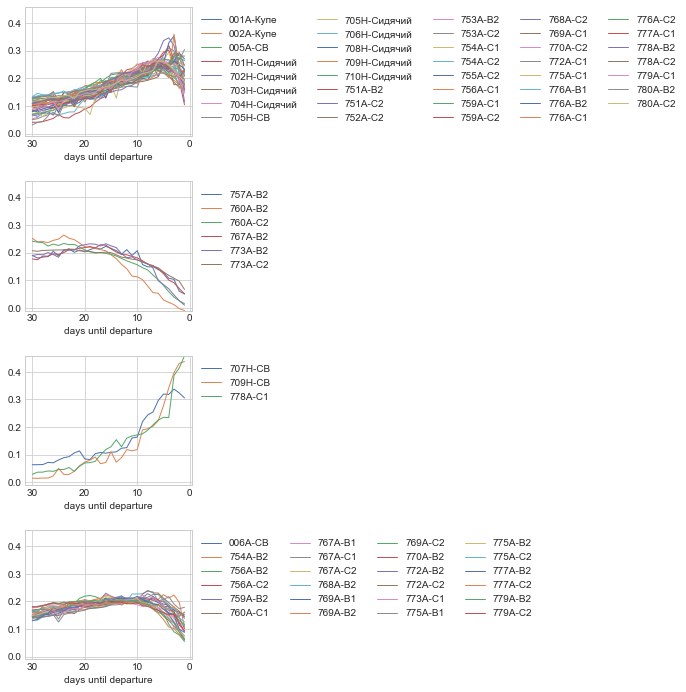

In [23]:
k = 4
kmeans = KMeans(n_clusters=k).fit(v.values)
eig_clusters = kmeans.predict(v.values)

ncols = 1
nrows = k

fig, axes = plt.subplots(ncols=ncols, nrows=nrows)
fig.set_size_inches(3 * ncols, 3 * nrows)
fig.subplots_adjust(hspace=0.35)
axes = axes.flatten()

vmin = v.min().min()
vmax = v.max().max()

for cluster, ax in zip(np.unique(eig_clusters), axes):
    vi = v.loc[eig_clusters == cluster]
    
    vi.T.plot(ax=ax, lw=1)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=vi.shape[0] // 8 + 1)
    ax.set_xlabel('days until departure')
    ax.set_ylim(vmin, vmax)
    
    ax.invert_xaxis()

for i in range(k, len(axes)):
    axes[i].axis('off')
    
plt.savefig('../data/figures/eigenvector_clusters.pdf', transparent=True, bbox_inches='tight')
# plt.close()

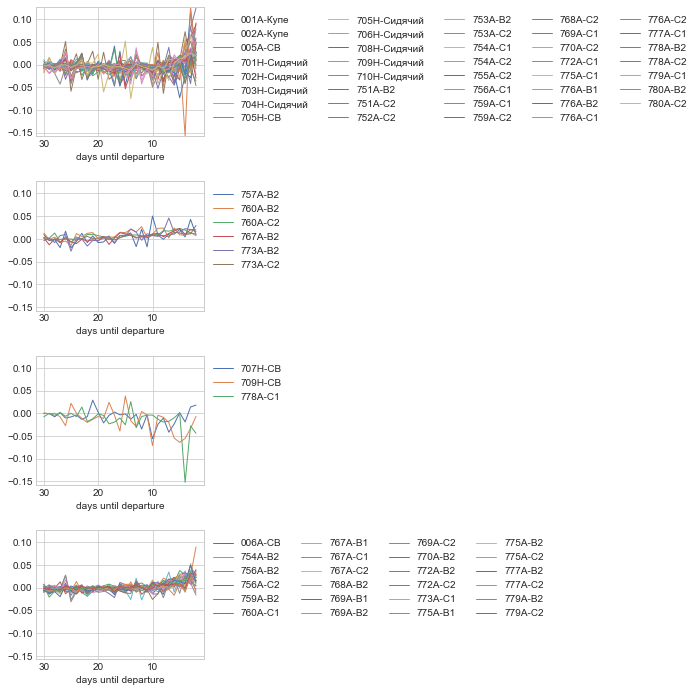

In [24]:
# k = 3
# kmeans = KMeans(n_clusters=k).fit(v.values)
# eig_clusters = kmeans.predict(v.values)

ncols = 1
nrows = k

fig, axes = plt.subplots(ncols=ncols, nrows=nrows)
fig.set_size_inches(3 * ncols, 3 * nrows)
fig.subplots_adjust(hspace=0.35)
axes = axes.flatten()

int_vmin = integral_v.min().min()
int_vmax = integral_v.max().max()

for cluster, ax in zip(np.unique(eig_clusters), axes):
    vi = integral_v.loc[eig_clusters == cluster]
    
    vi.T.plot(ax=ax, lw=1)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=vi.shape[0] // 8 + 1)
    ax.set_xlabel('days until departure')
    ax.set_ylim(int_vmin, int_vmax)
    
    ax.invert_xaxis()

for i in range(k, len(axes)):
    axes[i].axis('off')
    
plt.savefig('../data/figures/integral_eigenvector_clusters.pdf', transparent=True, bbox_inches='tight')
# plt.close()

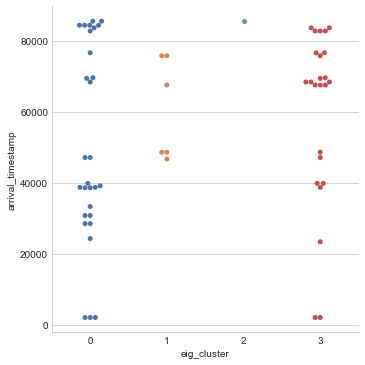

In [25]:
df = pd.Series(eig_clusters, index=v.index, name='eig_cluster')
df.index.name = 'train'
df = df.reset_index()

df = df.merge(data[['train', 'arrival_timestamp']], on='train', how='left')\
    .drop_duplicates('train').dropna()
df = df.set_index('train')

sns.catplot(data=df, x='eig_cluster', y='arrival_timestamp', kind='swarm')

### Би-кластеризация

In [26]:
clusters = pd.DataFrame({'mu': mu_clusters, 'eig': eig_clusters})

clusters['both'] = clusters['mu'].astype(str) + '-' + clusters['eig'].astype(str)

biclusters = clusters['both'].values

clusters.head(2)

,mu,eig,both
0,0,0,0-0
1,0,0,0-0


In [27]:
contingency_table = clusters.copy()
contingency_table['count'] = 1
contingency_table = contingency_table.groupby(['mu', 'eig'])['count'].sum().reset_index()\
    .pivot(index='mu', columns='eig', values='count').fillna(0)

contingency_table

eig,0,1,2,3
mu,,,,
0,19.0,0.0,0.0,13.0
1,1.0,4.0,0.0,10.0
2,19.0,0.0,3.0,1.0
3,0.0,2.0,0.0,0.0


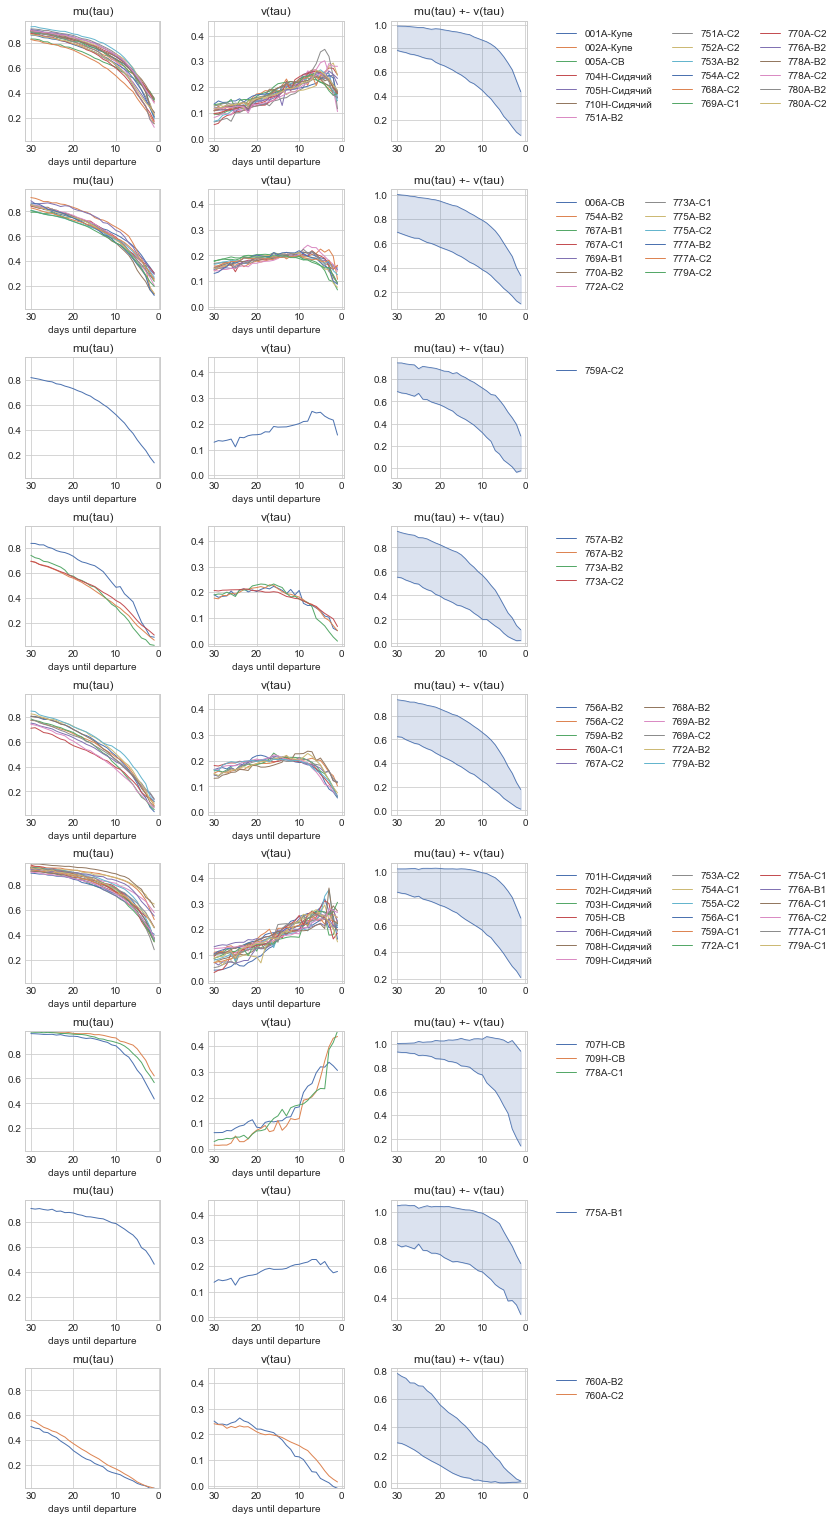

In [29]:
ncols = 3
nrows = np.unique(biclusters).size

fig, axes = plt.subplots(ncols=ncols, nrows=nrows)
fig.set_size_inches(3 * ncols, 3 * nrows)
fig.subplots_adjust(hspace=0.4, wspace=0.35)

for cluster, (ax1, ax2, ax3) in zip(np.unique(biclusters), axes):
    mean_i = mean.loc[biclusters == cluster]
    
    mean_i.T.plot(ax=ax1, lw=1, legend=False)
    ax1.set_title('mu(tau)')
    ax1.set_xlabel('days until departure')
    ax1.set_ylim(mu_min, mu_max)
    
    ax1.invert_xaxis()
    
    vi = v.loc[biclusters == cluster]
    
    vi.T.plot(ax=ax2, lw=1)
    ax2.legend(loc='upper left', bbox_to_anchor=(2.5, 1), ncol=vi.shape[0] // 8 + 1)
    ax2.set_title('v(tau)')
    ax2.set_xlabel('days until departure')
    ax2.set_ylim(vmin, vmax)
    
    ax2.invert_xaxis()
    
    mean_i = mean_i.mean(axis=0)
    vi = vi.mean(axis=0)
    
    lower = mean_i - vi
    upper = mean_i + vi
    
    ax3.plot(lower, c='C0', lw=0.8)
    ax3.plot(upper, c='C0', lw=0.8)
    ax3.fill_between(mean_i.index, lower, upper, color='C0', alpha=0.2)
    ax3.set_title('mu(tau) +- v(tau)')
    ax2.set_xlabel('days until departure')
    
    ax3.invert_xaxis()

plt.savefig('../data/figures/biclusters.pdf', transparent=True, bbox_inches='tight')
# plt.close()

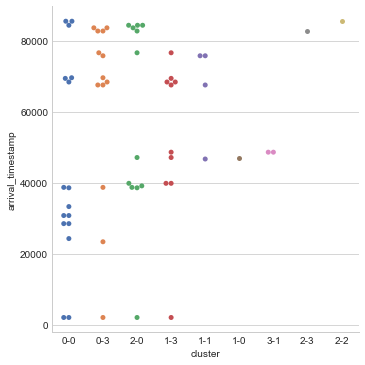

In [30]:
df = pd.Series(biclusters, index=mean.index, name='cluster')
df.index.name = 'train'
df = df.reset_index()

df = df.merge(data[['train', 'arrival_timestamp']], on='train', how='left')\
    .drop_duplicates('train').dropna()
df = df.set_index('train')

sns.catplot(data=df, x='cluster', y='arrival_timestamp', kind='swarm')

In [32]:
!jupyter nbconvert --to html 2_model.ipynb

[NbConvertApp] Converting notebook 2_model.ipynb to html
[NbConvertApp] Writing 2276361 bytes to 2_model.html


Расшифровка моделей для каждого кластера.